In [ ]:
import keras, math
from keras import preprocessing, applications
from keras.applications.xception import Xception, preprocess_input
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
from functools import partial, update_wrapper
import datetime
from keras import backend as K
from sklearn import metrics
import itertools
from keras.layers import Conv2D, Dense, MaxPooling2D, Flatten, Dropout, BatchNormalization, GlobalMaxPooling2D
from keras.optimizers import Adam,RMSprop, SGD
from keras.callbacks import ReduceLROnPlateau, LearningRateScheduler, ModelCheckpoint
import tensorflow as tf
from datetime import datetime
from requests import get
from google.colab import drive
import os

In [ ]:
!wget --output-document dataset.zip https://www.dropbox.com/s/lh7sqc1xtjo6duw/dataset_aumentado_todas.zip?dl=0
!unzip -o -q dataset.zip
drive.mount('/content/gdrive')

nome_treino = get('http://172.28.0.2:9000/api/sessions').json()[0]['name'].split(".")[0]+'/'
diretorio = '/content/dataset_aumentado/'
dir_teste = os.path.join(diretorio, 'test')
dir_treino = os.path.join(diretorio, 'train')
dir_validation = os.path.join(diretorio, 'validation')
dir_pesos = '/content/gdrive/MyDrive/pesos/'
dir_pesos_model = dir_pesos+nome_treino
latest = '/content/gdrive/MyDrive/ana/exp 1/model_checkpoint_weights_callback.weights.best.hdf5'


--2021-06-24 17:28:37--  https://www.dropbox.com/s/lh7sqc1xtjo6duw/dataset_aumentado_todas.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:6022:18::a27d:4212
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/lh7sqc1xtjo6duw/dataset_aumentado_todas.zip [following]
--2021-06-24 17:28:38--  https://www.dropbox.com/s/raw/lh7sqc1xtjo6duw/dataset_aumentado_todas.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc7f57dc0c9cb23f84154146a502.dl.dropboxusercontent.com/cd/0/inline/BRAzz5GLeZEHkvH-LXK8G5oIgBmY_ydY0IfkQt9Twg334VZIbhazyf8J2NkCA1AlqaLaUTtNHPKC6U1Civ-WYakS0eBnppfgNhg7yu2Q3p4JhTW1yk_WSNsS--oK0wG_82ikxkirz0Rtlta0DYLzSPG9/file# [following]
--2021-06-24 17:28:38--  https://uc7f57dc0c9cb23f84154146a502.dl.dropboxusercontent.com/cd/0/inline/BRAzz5GLeZEHkvH-LXK8G5oIgBmY_ydY0IfkQt9

In [ ]:

#definição do data augmentation e geradores de treino, teste e validacao
batch = 12
target_size_dimension= 300
#peso para cada uma das classes, como o generator organiza as classes de maneira alfanumerica, basta ordenar
#por nome que se consegue obter os repesctivos pesos de cada umas das classes

pesos_por_classe = [0.09005656445370647, 0.08023221196784758, 0.08008335814230426, 0.08484668055969039,
                    0.07368264364394166, 0.08350699612980053, 0.07695742780589461, 0.08350699612980053,
                    0.0867817802917535, 0.09333134861565942, 0.08186960404882405, 0.08514438821077702]


treino_datagen = keras.preprocessing.image.ImageDataGenerator(preprocessing_function=keras.applications.xception.preprocess_input)

validacao_datagen = keras.preprocessing.image.ImageDataGenerator(preprocessing_function=keras.applications.xception.preprocess_input)

teste_datagen = keras.preprocessing.image.ImageDataGenerator(preprocessing_function=keras.applications.xception.preprocess_input)

treino_set = treino_datagen.flow_from_directory(dir_treino,
                                              target_size=(target_size_dimension, target_size_dimension),
                                              class_mode='categorical',
                                              batch_size=batch)

validacao_set = treino_datagen.flow_from_directory(dir_validation,
                                              target_size=(target_size_dimension, target_size_dimension),
                                              class_mode='categorical',
                                              batch_size=batch)

teste_set = teste_datagen.flow_from_directory(dir_teste, 
                                            target_size=(target_size_dimension, target_size_dimension),
                                            class_mode='categorical',
                                            batch_size=1,
                                            shuffle=False)

Found 6718 images belonging to 12 classes.
Found 132 images belonging to 12 classes.
Found 72 images belonging to 12 classes.


In [ ]:
def focal_loss(gamma=2., alpha=4.):

    gamma = float(gamma)
    alpha = float(alpha)

    def focal_loss_fixed(y_true, y_pred):
        epsilon = 1.e-9
        y_true = tf.convert_to_tensor(y_true, tf.float32)
        y_pred = tf.convert_to_tensor(y_pred, tf.float32)

        model_out = tf.add(y_pred, epsilon)
        ce = tf.multiply(y_true, -tf.math.log(model_out))
        weight = tf.multiply(y_true, tf.pow(tf.subtract(1., model_out), gamma))
        fl = tf.multiply(alpha, tf.multiply(weight, ce))
        reduced_fl = tf.reduce_max(fl, axis=1)
        return tf.reduce_mean(reduced_fl)
    return focal_loss_fixed

In [ ]:
#step decay
def step_decay(epoch):
   initial_lrate = 0.0001
   flattern_factor = initial_lrate ** 2.25
   epochs_drop = 5.0
   drop = initial_lrate **(flattern_factor/epochs_drop)
   
   lrate = initial_lrate * math.pow(drop,  
           math.floor((epoch)/epochs_drop))
   return lrate

#exp decay
def exp_decay(epoch):
   initial_lrate = 0.1
   n_epochs = 5.0
   flattern_factor = initial_lrate ** 2.25
   #eu realmente nao entendi isso aqui
   k = math.log((initial_lrate**flattern_factor)/initial_lrate)/(n_epochs*math.log(math.e))
   lrate = initial_lrate * math.exp(-k*epoch)
   return lrate


class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
       self.losses = []
       self.lr = []
 
    def on_epoch_end(self, batch, logs={}):
       self.losses.append(logs.get('loss'))
       self.lr.append(step_decay(len(self.losses)))

In [ ]:
def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

def recall_function(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_function(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_function(y_true, y_pred):
    precision = precision_function(y_true, y_pred)
    recall = recall_function(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
model = Xception(
    include_top=False,
    weights="imagenet",
    pooling='avg',
    input_shape=(target_size_dimension, target_size_dimension, 3)
)

#fine_tune = 133

x = Dense(40, activation='relu')(model.output)
x = Dropout(0.25)(x)
output = Dense(12, activation='softmax')(x)
model_novo = keras.models.Model(model.input, output)
model_novo.load_weights(latest)

'''
if fine_tune > 0:
   for layer in model.layers[:-fine_tune]:
            layer.trainable = False
else:
   for layer in model.layers:
            layer.trainable = False
'''

loss_history = LossHistory()
#lrate = LearningRateScheduler(exp_decay)
estop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15)
lrate = LearningRateScheduler(step_decay)

model_checkpoint_weights_callback = keras.callbacks.ModelCheckpoint(
    filepath=dir_pesos_model,
    save_weights_only=True,
    monitor='val_f1_function',
    mode='max',
    save_best_only=True)

callbacks_list = [loss_history, estop, lrate, model_checkpoint_weights_callback]

def setup_model (model_novo, fine_tune):
  for layer in model_novo.layers [:(len(model_novo.layers)-fine_tune)]:
    layer.trainable = False
  for layer in model_novo.layers [(len(model_novo.layers)-fine_tune):]:
    layer.trainable = True

  model_novo.compile(optimizer='sgd', loss=focal_loss(alpha=1), metrics=['accuracy', f1_function, precision_function, recall_function])

#model_novo.compile(optimizer='sgd', loss=focal_loss(alpha=1), metrics=['accuracy', f1_function,precision_function, recall_function])
setup_model(model_novo,60)

#Mostra a duração do tempo de treinamento do modelo
start = datetime.now()

for i, layer in enumerate(model_novo.layers):
  print(i, layer.name, layer.trainable)

history = model_novo.fit(treino_set, steps_per_epoch=treino_set.samples/batch,
              epochs=100, validation_data=validacao_set, validation_steps=validacao_set.samples/batch, shuffle=True, verbose=True, callbacks=callbacks_list)

duracao=datetime.now() - start
print("Treino completo no tempo: ", duracao)

83697664/83683744 [==============================] - 1s 0us/step
0 input_1 False
1 block1_conv1 False
2 block1_conv1_bn False
3 block1_conv1_act False
4 block1_conv2 False
5 block1_conv2_bn False
6 block1_conv2_act False
7 block2_sepconv1 False
8 block2_sepconv1_bn False
9 block2_sepconv2_act False
10 block2_sepconv2 False
11 block2_sepconv2_bn False
12 conv2d False
13 block2_pool False
14 batch_normalization False
15 add False
16 block3_sepconv1_act False
17 block3_sepconv1 False
18 block3_sepconv1_bn False
19 block3_sepconv2_act False
20 block3_sepconv2 False
21 block3_sepconv2_bn False
22 conv2d_1 False
23 block3_pool False
24 batch_normalization_1 False
25 add_1 False
26 block4_sepconv1_act False
27 block4_sepconv1 False
28 block4_sepconv1_bn False
29 block4_sepconv2_act False
30 block4_sepconv2 False
31 block4_sepconv2_bn False
32 conv2d_2 False
33 block4_pool False
34 batch_normalization_2 False
35 add_2 False
36 block5_sepconv1_act False
37 block5_sepconv1 False
38 block5_sepcon

In [ ]:
def grafico(nome_modelo):

    plt.plot(nome_modelo.history['accuracy'])
    plt.plot(nome_modelo.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()

    plt.plot(nome_modelo.history['loss'])
    plt.plot(nome_modelo.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper right')
    plt.show()

    plt.plot(nome_modelo.history['f1_m'])
    plt.plot(nome_modelo.history['val_f1_m'])
    plt.title('Model F1_Score')
    plt.ylabel('F1_Score')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper right')
    plt.show()

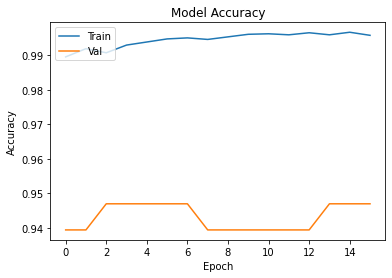

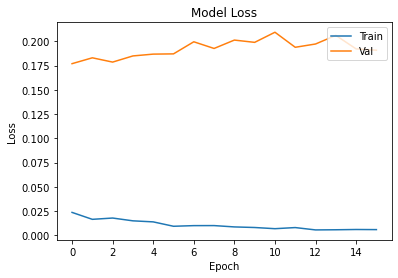

KeyError: ignored

In [ ]:
grafico(history)

In [ ]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):

    plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def confusion_matrix(test_data_generator, model):
  test_data_generator.reset()
  predictions = model.predict(test_data_generator, steps=teste_set.samples)
  # Get most likely class
  predicted_classes = np.argmax(predictions, axis=1)
  true_classes = test_data_generator.classes
  class_labels = list(test_data_generator.class_indices.keys())
  print(class_labels)  

  report = metrics.classification_report(true_classes, predicted_classes, target_names=class_labels)
  cm = metrics.confusion_matrix(true_classes, predicted_classes)
  print(report)
  plot_confusion_matrix(cm, class_labels)

In [ ]:
confusion_matrix(teste_set, model_novo)

In [ ]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

def plot_roc(predictions,gold,model_name):
  pred_ravel = predictions.ravel()
  fpr, tpr, thresholds = roc_curve(gold, predictions)
  _auc = auc(fpr, tpr)
  plt.figure(1)
  plt.plot([0, 1], [0, 1], 'k--')
  plt.plot(fpr, tpr, label=model_name +' (area = {:.3f})'.format(_auc))
 # plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
  plt.xlabel('False positive rate')
  plt.ylabel('True positive rate')
  plt.title('ROC curve')
  plt.legend(loc='best')
  plt.show()


In [ ]:
n_class = 12

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(teste_datagen, pred_prob[:,i], pos_label=i)
    
# plotting    
plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label='Class 0 vs Rest')
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Class 1 vs Rest')
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Class 2 vs Rest')
plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')